# Lab Six: CNNs

### Garrett Webb, Jackson Heck, and Maria Harrison

## 1. Preparation

### 1.1 Choose Metric

Since we are using a weather dataset, we thought one metric to evaluate our algorithm's performance that might be useful is top k categorical accuracy. This accuracy metric evaluates if the correct class was in the top k predicted classes. In the case of weather, this algorithm would mainly be used to predict the weather. When it comes to weather, people are mainly concerned with weather forecasts such as rain, shine, stormy, and cloudy. These can affect the everyday person's life as well as sectors such as agriculture, transportation, and infrastructure. Thus, it is most importan to know whether the predicted weather will be simply good or bad for the task that is necessary. Thus, the categories can simply be split into so-called good weather and bad weather. Our dataset has the four classes: cloudy, rain, shine, and sunrise. We mainly want to know whether the weather will be cloudy/rain or shine/sunrise. Thus, we can set the number of top predicted classes to 2. Then, we can evaluate if the class was at least predicted in either its category or the closest category to it. For example, if it is a rain image, then we want to see if rain and cloudy are the top two predicted classes. 

Keras also provides several classification metrics based on true/false positives and negatives. Unfortunately, they do not always adapt well to multi-class classification problems. For a weather dataset, we would be interested in false negatives. For example, if there was a weather image that was classified as rain or cloudy (or storm in actual practice), but our algorithm incorrectly classified these images as shine or sunrise. This would cause concern for those who used our algorithm in practice. Thus, calculating the number of false negatives could be a valuable metric for determining the worth of our algorithm. Additionally, calculating the recall, which divides true positives by the sum of true positives and false negatives, would also be valuable for evaluating our algorithm's performance. 

In the modeling section of our report, we primarily tested using categorical accuracy as this was the easiest metric to implement. However, we also did look at false negatives and top k categorical accuracy. 

### 1.2 Choose Method for Dividing Data

The dataset we are using contains various weather images. The four classes of images are cloudy, rain, shine, and sunrise images. Our current dataset does not contain an equal amount of images for each class. Thus, we definitely will want to use stratified sampling so that our training and test sets represent the actual percentage of images of each class. Most often in real practice, the number of images in each class will not always be the same. Additionally, many weather forecasts are primarily concerned with unfavorable weather conditions and accurately predicting and classifying those. Thus, their datasets will favor those images and use more of those for training. Therefore, this is both good practice for our dataset and for our algorithm being used in practice. We will also want to use k-fold cross validation for our dataset since our dataset does not have a very large number of samples. Thus, we can resample with different groups of samples in our dataset to train on. In actual practice, if a weather dataset has a large number of samples, then we would not necessarily need to use k-fold cross validation. However, for this specific dataset, it will be useful. Since we want to use stratified sampling and k-fold cross-validation, then we will want to use stratified 10-fold cross validation so we can resample from our dataset while maintaining the ratio of each target class in each fold. 

Below, we read in the images and placed them in a dataframe to be later used for training and testing.

In [1]:
# read in images as numpy arrays
import numpy as np
import os
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages')
sys.path.append('/usr/local/anaconda3/lib/python3.9/site-packages')
import cv2

folder_names = ['cloudy', 'rain', 'shine', 'sunrise']

image_name_array = []

X_array = []

X_blue_array = []
X_green_array = []
X_red_array = []

X_gray_array = []

class_labels = []
i = 0

h = 70
w = 70

for name in folder_names:
    directory = '/Users/marycateharrison/Library/Mobile Documents/com~apple~CloudDocs/SMU/spring-2023/machine-learning/weather-dataset/' + name + '/'
    for file in os.listdir(directory):
        try:
            path = os.path.join(directory, file)
            
            # read image
            im = cv2.imread(path, 1)
            
            # resize image to 70 x 70 pixels and convert to RGB
            new_im = cv2.resize(im, dsize=(h, w), interpolation=cv2.INTER_NEAREST)
            image = cv2.cvtColor(new_im, 4)
            
            # iterate through pixels of image and append to array
            x_array = []
            for x in np.nditer(image):
                x_array.append(x)
            
            # append array of pixels of one image to array holding pixels of all images
            X_array.append(x_array)
            
            split_filename = os.path.splitext(file)
            
            class_labels.append(name)
            
            image_name_array.append(split_filename[0])
            
        except Exception as e:
            print(path)
            print(str(e))
            
# turn arrays into numpy arrays          
X = np.asarray(X_array)
y_row = np.asarray(class_labels)
y = y_row.reshape(-1,1)
print(y.shape)

X = X.reshape((X.shape[0],70,70,3)) # reshape as images
print(X.shape)

/Users/marycateharrison/Library/Mobile Documents/com~apple~CloudDocs/SMU/spring-2023/machine-learning/weather-dataset/rain/rain141.jpg
OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

/Users/marycateharrison/Library/Mobile Documents/com~apple~CloudDocs/SMU/spring-2023/machine-learning/weather-dataset/shine/shine131.jpg
OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

(1123, 1)
(1123, 70, 70, 3)


In [2]:
NUM_CLASSES = 4

Next, we split the dataset into its training and testing counterparts with stratification on the target class to retain accurate percentages of each class.

In [3]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

import pandas as pd 

df = pd.DataFrame(y)
y = df.replace(['cloudy', 'rain', 'shine', 'sunrise'],[0, 1, 2, 3])
y = y.to_numpy()

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


2023-05-03 15:16:52.826723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Here are a few images from the training dataset.

/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


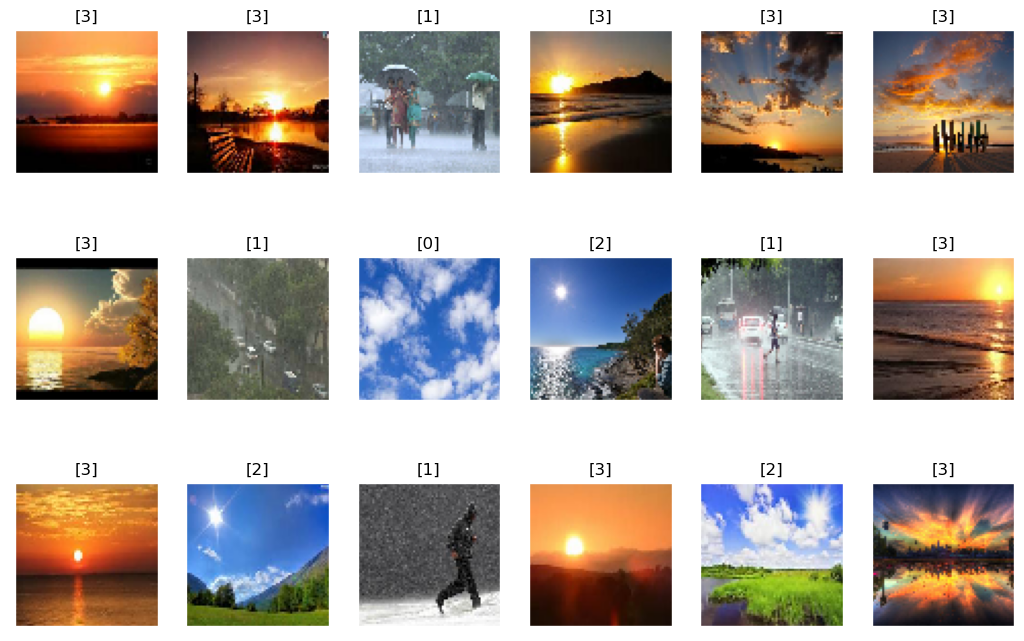

In [4]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        ## convert to RGB
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 70, 70) # defaults to showing a 3 by 6 subset of the images

## 2. Modeling

### 2.1 Setup Data Expansion for Training

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomBrightness, RandomHeight, RandomWidth
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import average 
from tensorflow.keras.models import  Model

Note: We did go back and change some of our initial settings due to discoveries in modeling.

We used the keras ImageGenerator as a pre-processing step. We decided to set the rotation range to an 8 degree range for random rotations. We did not think this specific parameter was super useful to our image dataset but could be fairly useful for rain and cloud images. We set the channel shift range to 80. This could be useful for images that include colors such as sunrise and shine images. For the fill mode, we decided to use nearest, so the boundaries are filled with the colors directly on the inside of the boundaries. We thought both vertical and horizontal flip could be useful for our weather images. We have already scaled our images previously, so using rescale was not necessary. 

In [33]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0, 
    width_shift_range=0.0, 
    height_shift_range=0.0, 
    brightness_range=(0.0,0.0), 
    shear_range=0.0, 
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)

datagen.fit(X_train)

### 2.2 Create CNNs

We one-hot encoded the classes to use for categorical cross entropy.

In [7]:
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [8]:
print('New Shape: Rows: %d, image size: (%d,%d,%d)' % (X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3] ))

New Shape: Rows: 898, image size: (70,70,3)


In [18]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

labels = ['cloudy', 'rain', 'shine', 'sunrise']
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    print("Confusion Matrix")
    print(mt.confusion_matrix(y_test,yhat))
    print("Classification Report")
    print(mt.classification_report(y_test,yhat))
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels,yticklabels=labels)
    plt.title(title_text+'{:.4f}'.format(acc))

We tested different augmentations on a simple cnn to see what augmentations affected our model positively in terms of the metric of accuracy.

In [20]:
%%time 

cnn_test = Sequential()

cnn_test.add(RandomFlip("horizontal_and_vertical"))
# cnn_test.add(RandomBrightness(factor=0.3))
# cnn_test.add(RandomHeight(factor=(0.2,0.4)))
# cnn_test.add(RandomWidth(factor=(0.2,0.4)))
# cnn_test.add(RandomRotation(factor=0.5))

# let's start with an AlexNet style convolutional phase
cnn_test.add(Conv2D(filters=32,
                input_shape = (h,w,3),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn_test.add(Conv2D(filters=64,
                kernel_size=(3,3),
                padding='same', 
                activation='relu',)) # more compact syntax

cnn_test.add(MaxPooling2D(pool_size=(2, 2)))

# add one layer on flattened output
# cnn.add(Flatten())
cnn_test.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn_test.add(Flatten())
cnn_test.add(Dense(128, activation='relu'))
cnn_test.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn_test.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn_test.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# # the flow method yields batches of images indefinitely, with the given transformations
cnn_test.fit(X_train, y_train_ohe, batch_size=32, 
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe))

Epoch 1/5
29/29 [==============================] - 9s 278ms/step - loss: 256.0799 - accuracy: 0.5535 - val_loss: 0.7052 - val_accuracy: 0.7111
Epoch 2/5
29/29 [==============================] - 8s 271ms/step - loss: 1.1440 - accuracy: 0.6592 - val_loss: 0.6136 - val_accuracy: 0.7778
Epoch 3/5
29/29 [==============================] - 8s 277ms/step - loss: 0.8385 - accuracy: 0.7094 - val_loss: 0.7496 - val_accuracy: 0.7333
Epoch 4/5
29/29 [==============================] - 8s 272ms/step - loss: 1.0423 - accuracy: 0.6971 - val_loss: 7.4010 - val_accuracy: 0.6578
Epoch 5/5
29/29 [==============================] - 8s 268ms/step - loss: 21.9186 - accuracy: 0.5412 - val_loss: 0.7259 - val_accuracy: 0.6800
CPU times: user 4min 29s, sys: 2min 21s, total: 6min 50s
Wall time: 40.4 s


8/8 [==============================] - 0s 39ms/step
Confusion Matrix
[[28 29  3  0]
 [ 3 40  0  0]
 [24  9 17  0]
 [ 2  0  2 68]]
Classification Report
              precision    recall  f1-score   support

           0       0.49      0.47      0.48        60
           1       0.51      0.93      0.66        43
           2       0.77      0.34      0.47        50
           3       1.00      0.94      0.97        72

    accuracy                           0.68       225
   macro avg       0.69      0.67      0.65       225
weighted avg       0.72      0.68      0.67       225



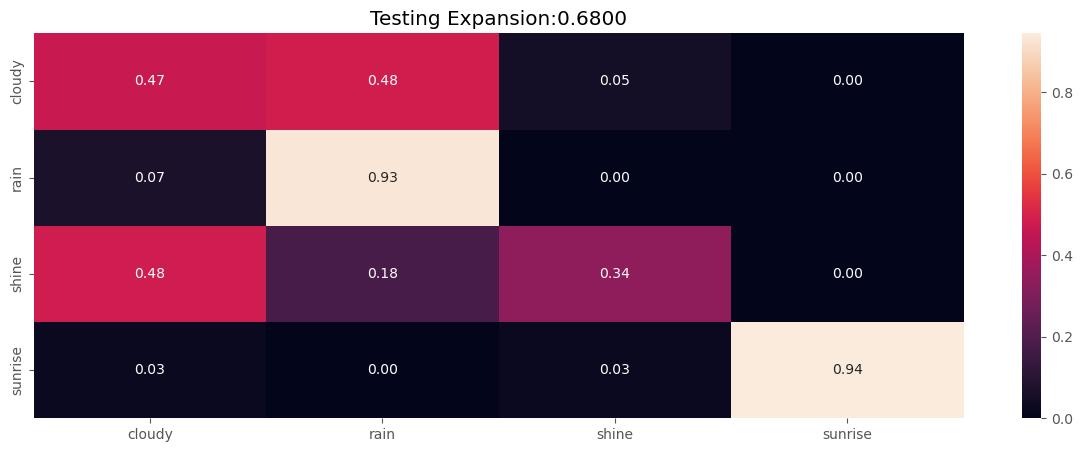

In [21]:
summarize_net(cnn_test, X_test, y_test, title_text='Testing Expansion:')

The testing above showed that several of the augementations that we assumed would be useful were not as helpeful as we originally thought. The main augmentation that was useful was the random flip both horizontal and vertical. 

In the confusion matrix, the diagonal values are the true positives. Different runs of calling predict were giving us about 65% of the testing set to return true positives. 

Since we are concerned with false negatives, the values of those would be the values in the rows that we're not along the diagonal. It varies on how you want to to classify this for a multi-class classification problem, but this is how we chose to calculate the false negatives. For the first class, the number of false negatives would be 29 + 3 + 0 = 32. For the second class, the number of false negatives would be 3 + 0 + 0 = 3. For the third class, the number of false negatives would be 24 + 9 + 0 = 33. For the last class, the number of false negatives would be 2 + 0 + 2 = 4. In total, this was the remaining percentage of the training set (about 35%). We would like our false negative rate to be lower around 15%. 

#### 2.2.1 LeNet architecture

We first tried the LeNet architecture style.

In [31]:
%%time
# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2 
l2_lambda = 0.0001

input_holder = Input(shape=(h,w,3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (h,w,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)


CPU times: user 117 ms, sys: 23.8 ms, total: 141 ms
Wall time: 114 ms


Epoch 1/50
8/8 [==============================] - 3s 309ms/step - loss: 3.7670 - accuracy: 0.4454 - val_loss: 0.8439 - val_accuracy: 0.5422
Epoch 2/50
8/8 [==============================] - 2s 286ms/step - loss: 0.8217 - accuracy: 0.6347 - val_loss: 0.6773 - val_accuracy: 0.6933
Epoch 3/50
8/8 [==============================] - 2s 295ms/step - loss: 0.6890 - accuracy: 0.7127 - val_loss: 0.6574 - val_accuracy: 0.7511
Epoch 4/50
8/8 [==============================] - 2s 299ms/step - loss: 0.6653 - accuracy: 0.7327 - val_loss: 0.5730 - val_accuracy: 0.7644
Epoch 5/50
8/8 [==============================] - 2s 289ms/step - loss: 0.6081 - accuracy: 0.7416 - val_loss: 0.5498 - val_accuracy: 0.7911
Epoch 6/50
8/8 [==============================] - 2s 288ms/step - loss: 0.5489 - accuracy: 0.7751 - val_loss: 1.0988 - val_accuracy: 0.5111
Epoch 7/50
8/8 [==============================] - 2s 290ms/step - loss: 0.6833 - accuracy: 0.7361 - val_loss: 0.5648 - val_accuracy: 0.8178
Epoch 8/50
8/8 [====

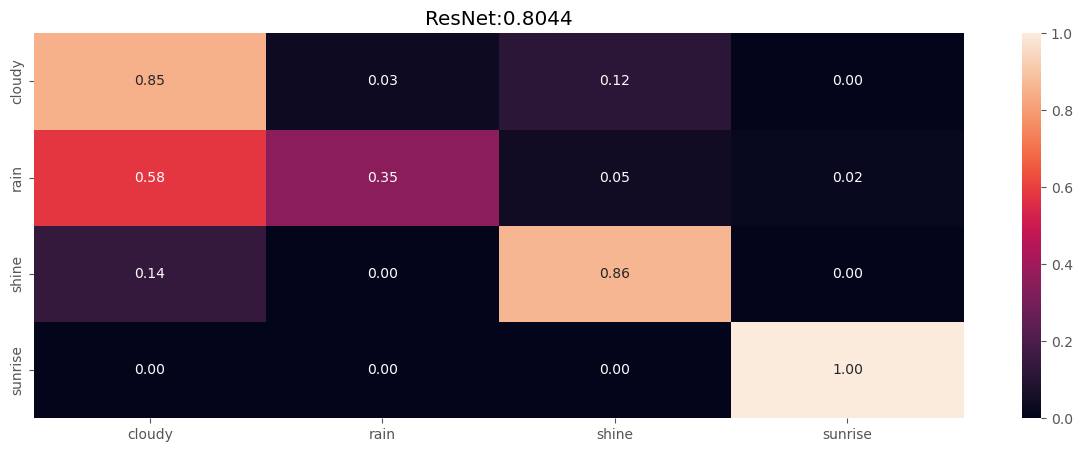

In [41]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

resnet_history = resnet.fit(X_train, y_train_ohe, batch_size=128, 
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

summarize_net(resnet, X_test, y_test, title_text='ResNet:')

Epoch 1/50


2023-05-03 19:39:53.419401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 3s 292ms/step - loss: 1.8119 - accuracy: 0.2628 - val_loss: 0.5699 - val_accuracy: 0.7867
Epoch 2/50
8/8 [==============================] - 2s 292ms/step - loss: 1.4382 - accuracy: 0.2661 - val_loss: 0.6769 - val_accuracy: 0.7467
Epoch 3/50
8/8 [==============================] - 2s 299ms/step - loss: 1.3705 - accuracy: 0.3007 - val_loss: 0.7445 - val_accuracy: 0.7200
Epoch 4/50
8/8 [==============================] - 2s 291ms/step - loss: 1.3712 - accuracy: 0.3163 - val_loss: 0.7746 - val_accuracy: 0.7156
Epoch 5/50
8/8 [==============================] - 0s 20ms/step
Confusion Matrix
[[37  0 21  2]
 [20  5  4 14]
 [ 2  0 47  1]
 [ 0  0  0 72]]
Classification Report
              precision    recall  f1-score   support

           0       0.63      0.62      0.62        60
           1       1.00      0.12      0.21        43
           2       0.65      0.94      0.77        50
           3       0.81      1.00      0.89        72

    accuracy    

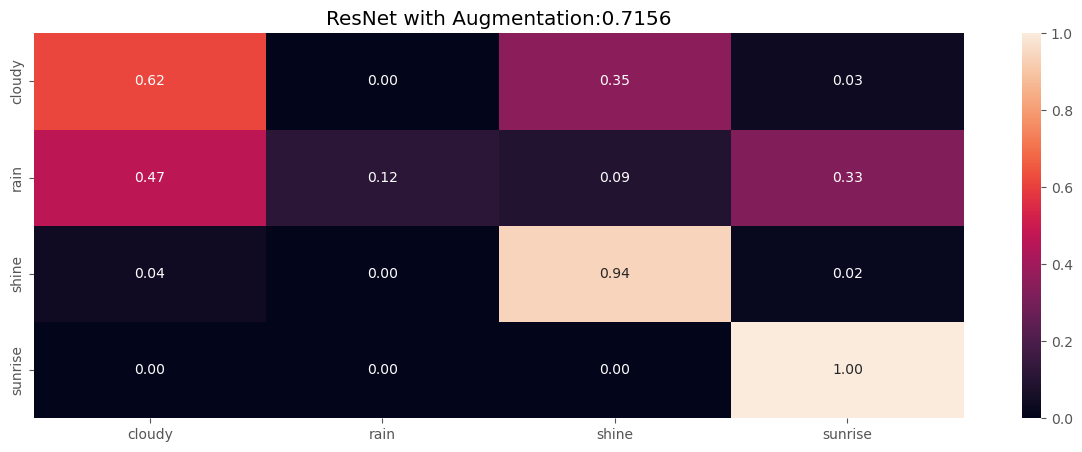

In [42]:
resnet_with_augmentation = resnet.fit(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      # steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

summarize_net(resnet, X_test, y_test, title_text='ResNet with Augmentation:')

The resnet with and without augmentation performed about the same each time it was fit. The resnet with augmentation performed worse when including the steps per epoch. Since the keras built in false negatives metric does not always calculate false negatives properly for multi-class classification, we calculated it ourselves. Sunrise images were always accurately predicted. Shine images were correctly predicted most of the time. Rain and cloudy images did not do as well on average. 

Text(0.5, 0, 'epochs')

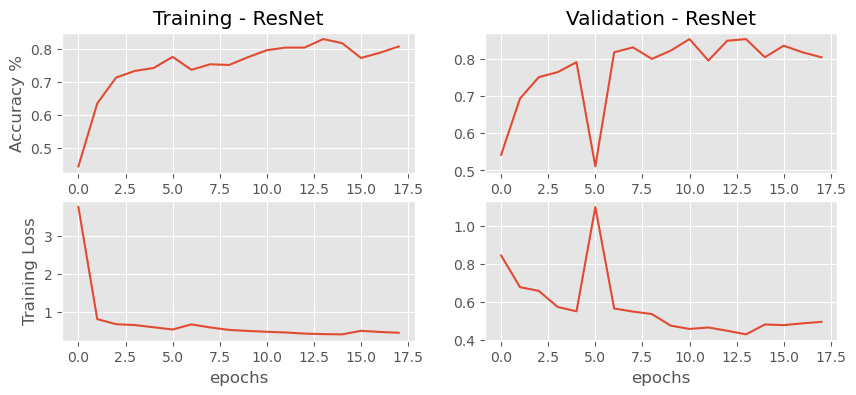

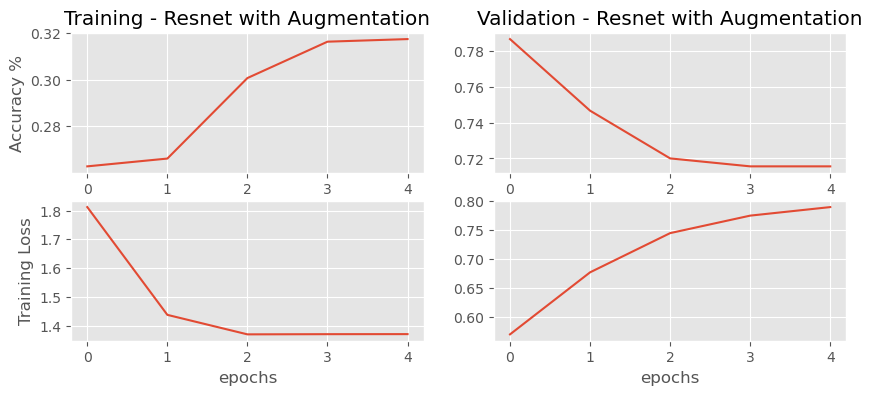

In [71]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(resnet_history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training - ResNet')
plt.subplot(2,2,2)
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Validation - ResNet')

plt.subplot(2,2,3)
plt.plot(resnet_history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(resnet_history.history['val_loss'])
plt.xlabel('epochs')

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(resnet_with_augmentation.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training - Resnet with Augmentation')
plt.subplot(2,2,2)
plt.plot(resnet_with_augmentation.history['val_accuracy'])
plt.title('Validation - Resnet with Augmentation')

plt.subplot(2,2,3)
plt.plot(resnet_with_augmentation.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(resnet_with_augmentation.history['val_loss'])
plt.xlabel('epochs')

Next, we changed some parameters of the previous network. We tried some different kernel initializers and regularizer combinations. We landed on using glorot uniform with a l1 and l2 regularizer. We also added an extra layer with 128 filters.

In [57]:
%%time

from tensorflow.keras.regularizers import l1_l2 
l1_lambda = 0.0001
l2_lambda = 0.0001

input_holder = Input(shape=(h,w,3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (h,w,3),
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# x = Conv2D(filters=64,
#                kernel_size=(1,1),
#                kernel_initializer='glorot_uniform', 
#                kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
#                padding='same', 
#                activation='relu', 
#                data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

CPU times: user 118 ms, sys: 18.3 ms, total: 137 ms
Wall time: 115 ms


Epoch 1/50
8/8 [==============================] - 4s 391ms/step - loss: 96.5245 - accuracy: 0.2851 - val_loss: 12.6346 - val_accuracy: 0.5200
Epoch 2/50
8/8 [==============================] - 3s 333ms/step - loss: 6.7834 - accuracy: 0.4399 - val_loss: 1.8478 - val_accuracy: 0.5644
Epoch 3/50
8/8 [==============================] - 3s 320ms/step - loss: 2.3231 - accuracy: 0.4744 - val_loss: 1.5326 - val_accuracy: 0.6267
Epoch 4/50
8/8 [==============================] - 3s 321ms/step - loss: 1.8663 - accuracy: 0.5267 - val_loss: 1.4529 - val_accuracy: 0.5867
Epoch 5/50
8/8 [==============================] - 3s 318ms/step - loss: 1.7293 - accuracy: 0.5334 - val_loss: 1.4013 - val_accuracy: 0.6311
Epoch 6/50
8/8 [==============================] - 3s 324ms/step - loss: 1.5106 - accuracy: 0.5969 - val_loss: 1.2436 - val_accuracy: 0.6533
Epoch 7/50
8/8 [==============================] - 3s 331ms/step - loss: 1.3561 - accuracy: 0.6381 - val_loss: 1.1992 - val_accuracy: 0.6756
Epoch 8/50
8/8 [==

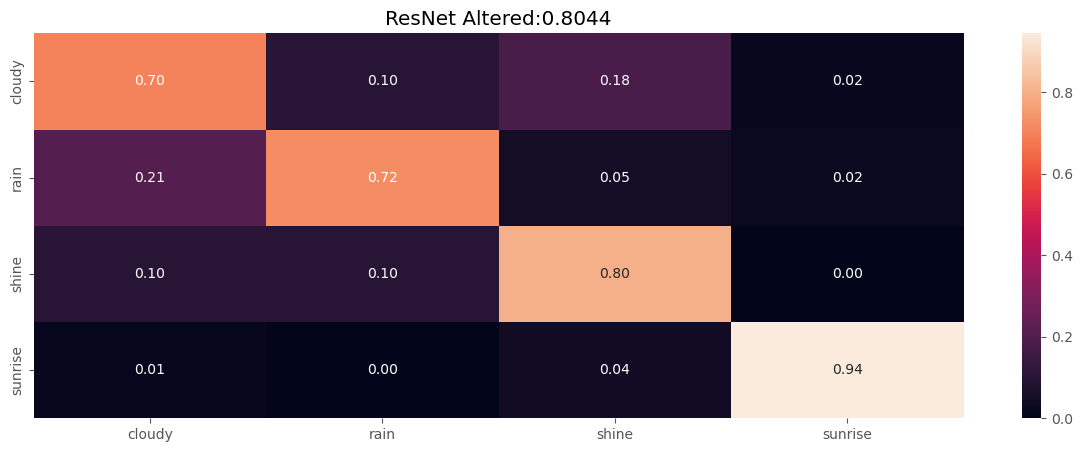

In [58]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

resnet_history_2 = resnet.fit(X_train, y_train_ohe, batch_size=128, 
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

summarize_net(resnet, X_test, y_test, title_text='ResNet Altered:')

Epoch 1/50


2023-05-03 20:01:38.105916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 4s 395ms/step - loss: 1.8340 - accuracy: 0.2461 - val_loss: 1.1469 - val_accuracy: 0.7733
Epoch 2/50
8/8 [==============================] - 3s 361ms/step - loss: 1.7834 - accuracy: 0.3085 - val_loss: 1.3167 - val_accuracy: 0.7689
Epoch 3/50
8/8 [==============================] - 3s 431ms/step - loss: 1.7837 - accuracy: 0.3040 - val_loss: 1.4072 - val_accuracy: 0.7644
Epoch 4/50
8/8 [==============================] - 3s 359ms/step - loss: 1.7797 - accuracy: 0.3341 - val_loss: 1.4468 - val_accuracy: 0.7556
Epoch 5/50
8/8 [==============================] - 0s 25ms/step
Confusion Matrix
[[26 20 14  0]
 [ 0 41  2  0]
 [ 4  6 40  0]
 [ 1  2  6 63]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.43      0.57        60
           1       0.59      0.95      0.73        43
           2       0.65      0.80      0.71        50
           3       1.00      0.88      0.93        72

    accuracy    

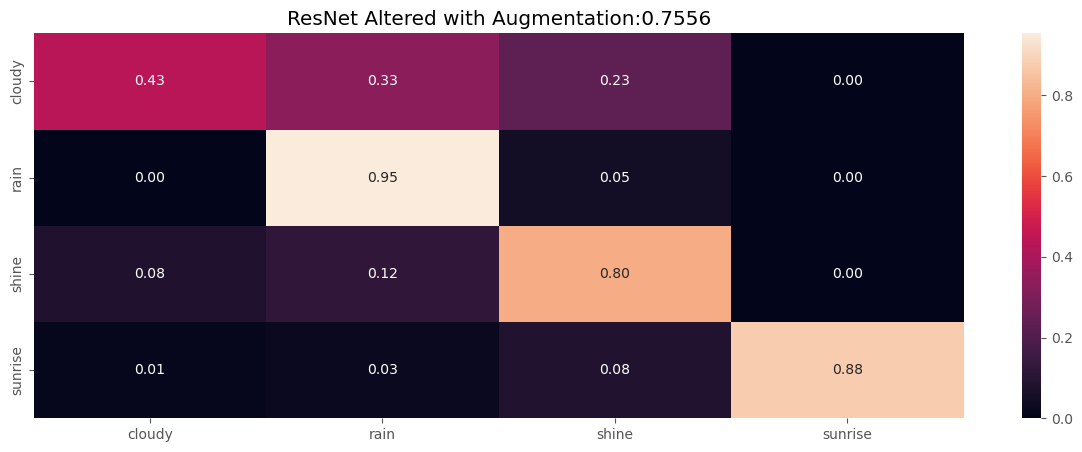

In [59]:
resnet_with_augmentation_2 = resnet.fit(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      # steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

summarize_net(resnet, X_test, y_test, title_text='ResNet Altered with Augmentation:')

The changes we made did perform somewhat better at least for the resnet with augmentation. The one with no augmentation performed about the same. Sunrise and shine images continued to perform well with accurate predictions. The rain images performed better overall with the new changes. The cloudy images performed better with no augmentation but continued to struggle accurately predicting with augmentation. The percentage of false negatives was lower with these new changes.

Text(0.5, 0, 'epochs')

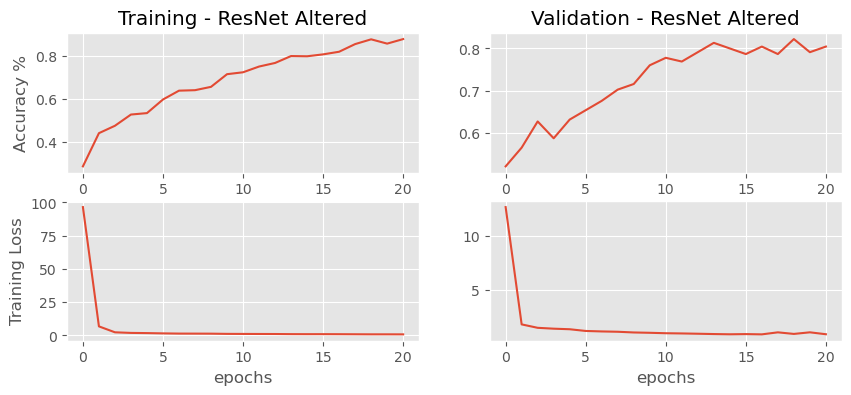

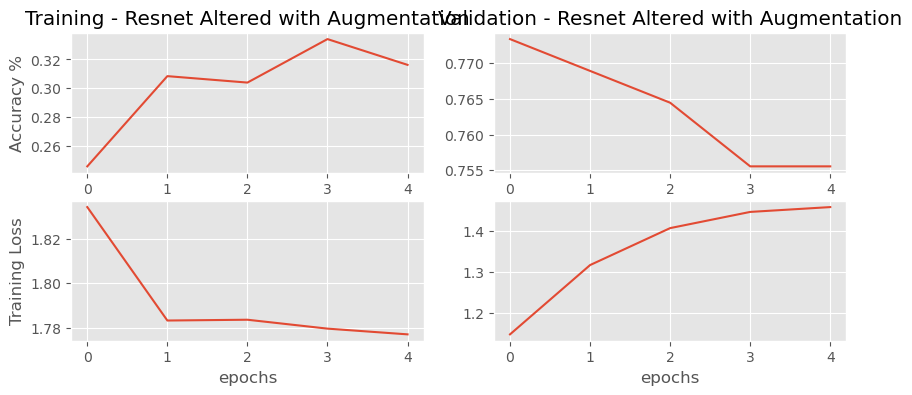

In [74]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(resnet_history_2.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training - ResNet Altered')
plt.subplot(2,2,2)
plt.plot(resnet_history_2.history['val_accuracy'])
plt.title('Validation - ResNet Altered')

plt.subplot(2,2,3)
plt.plot(resnet_history_2.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(resnet_history_2.history['val_loss'])
plt.xlabel('epochs')

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(resnet_with_augmentation_2.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training - Resnet Altered with Augmentation')
plt.subplot(2,2,2)
plt.plot(resnet_with_augmentation_2.history['val_accuracy'])
plt.title('Validation - Resnet Altered with Augmentation')

plt.subplot(2,2,3)
plt.plot(resnet_with_augmentation_2.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(resnet_with_augmentation_2.history['val_loss'])
plt.xlabel('epochs')

#### 2.2.2 Xception architecture

We next tried an Xception style architecture.

In [75]:
# Xception style architecture
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

l2_lambda = 0.000001



input_holder = Input(shape=(h, w, 3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (h,w,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = (h,w,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = (h,w,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)

Epoch 1/50
29/29 [==============================] - 3s 89ms/step - loss: 161.0486 - accuracy: 0.5134 - val_loss: 3.7852 - val_accuracy: 0.6711
Epoch 2/50
29/29 [==============================] - 2s 82ms/step - loss: 4.5208 - accuracy: 0.6648 - val_loss: 1.3334 - val_accuracy: 0.7733
Epoch 3/50
29/29 [==============================] - 2s 79ms/step - loss: 2.1358 - accuracy: 0.6626 - val_loss: 1.0912 - val_accuracy: 0.7244
Epoch 4/50
29/29 [==============================] - 2s 85ms/step - loss: 1.4583 - accuracy: 0.6704 - val_loss: 0.9389 - val_accuracy: 0.7244
Epoch 5/50
29/29 [==============================] - 2s 83ms/step - loss: 1.1482 - accuracy: 0.6815 - val_loss: 0.9635 - val_accuracy: 0.7467
Epoch 6/50
29/29 [==============================] - 2s 83ms/step - loss: 0.8252 - accuracy: 0.7283 - val_loss: 0.9382 - val_accuracy: 0.7467
Epoch 7/50
29/29 [==============================] - 2s 84ms/step - loss: 0.7806 - accuracy: 0.7517 - val_loss: 0.9964 - val_accuracy: 0.7422
Epoch 8/50


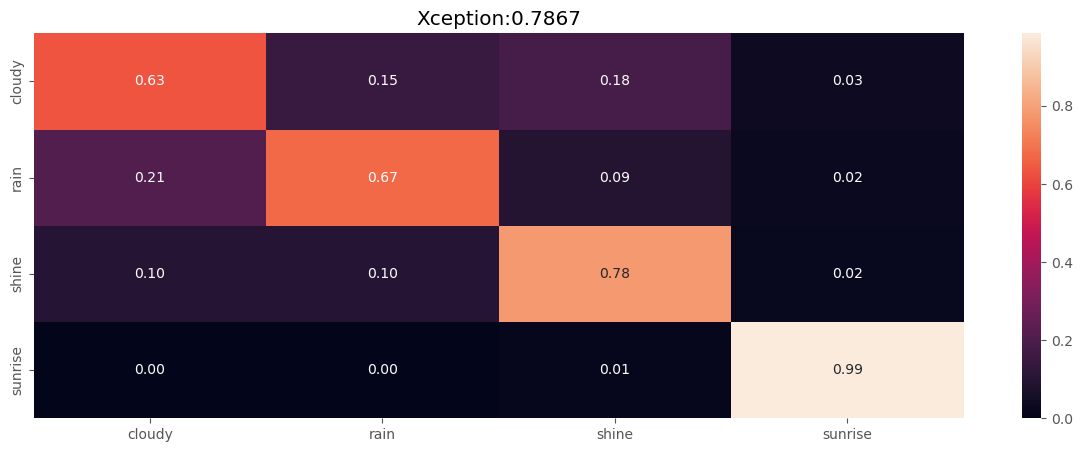

In [76]:
xception.compile(loss='categorical_crossentropy',
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

xception_history = xception.fit(X_train, y_train_ohe, batch_size=32,
            epochs=50, verbose=1,
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
            )

summarize_net(xception, X_test, y_test, title_text='Xception:')

Epoch 1/50


2023-05-03 20:20:54.761189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 3s 80ms/step - loss: 1.6560 - accuracy: 0.2617 - val_loss: 1.1140 - val_accuracy: 0.7511
Epoch 2/50
29/29 [==============================] - 2s 79ms/step - loss: 1.3813 - accuracy: 0.2728 - val_loss: 1.1349 - val_accuracy: 0.7556
Epoch 3/50
29/29 [==============================] - 2s 78ms/step - loss: 1.3675 - accuracy: 0.3185 - val_loss: 1.1452 - val_accuracy: 0.7644
Epoch 4/50
29/29 [==============================] - 2s 79ms/step - loss: 1.3824 - accuracy: 0.3018 - val_loss: 1.1444 - val_accuracy: 0.7600
Epoch 5/50
8/8 [==============================] - 0s 18ms/step
Confusion Matrix
[[29 10 14  7]
 [ 5 28  5  5]
 [ 2  5 42  1]
 [ 0  0  1 71]]
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.48      0.60        60
           1       0.65      0.65      0.65        43
           2       0.68      0.84      0.75        50
           3       0.85      0.99      0.91        72

    accuracy

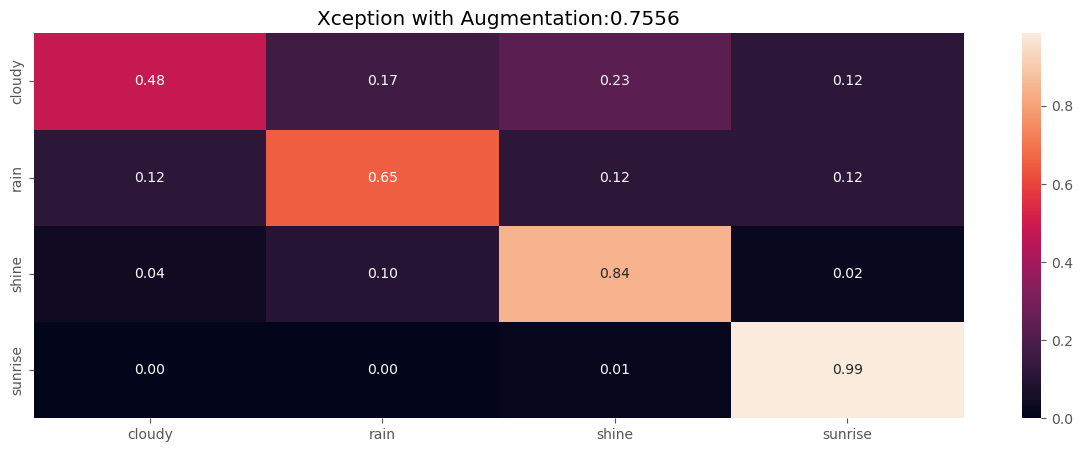

In [77]:
xception_with_augmentation = xception.fit(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                      # steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

summarize_net(xception, X_test, y_test, title_text='Xception with Augmentation:')

We can see that the xception without augmentation performed about the same as the resnet without augmentation. The xception with augmentation performed better than the resnet with augmentation. Sunrise images continued to predict well. The cloudy and rain images also seemed to perform better on average. These are the classes of images that are pretty important for our business use case. Thus, this does seem to be better for our needs. The percentage of false negatives was about the same.

Text(0.5, 0, 'epochs')

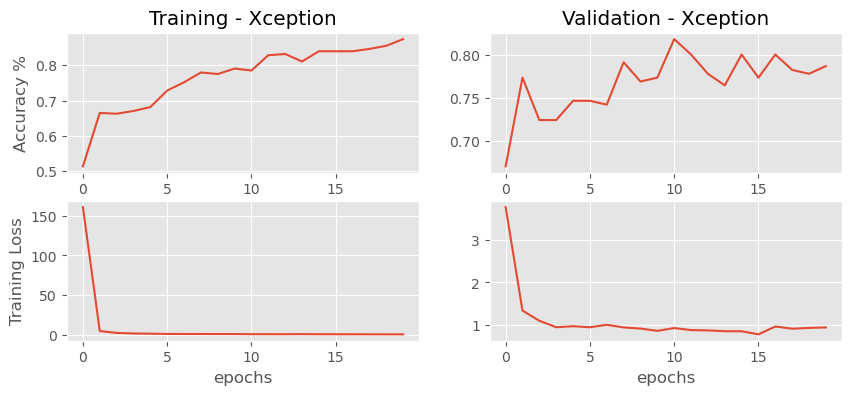

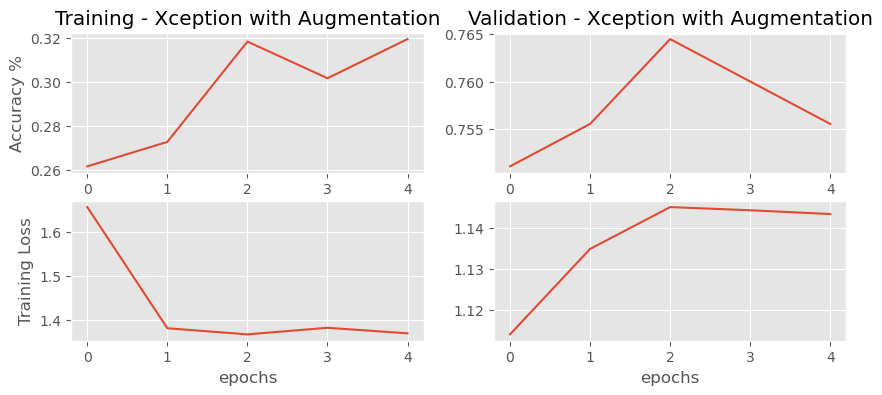

In [78]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(xception_history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training - Xception')
plt.subplot(2,2,2)
plt.plot(xception_history.history['val_accuracy'])
plt.title('Validation - Xception')

plt.subplot(2,2,3)
plt.plot(xception_history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(xception_history.history['val_loss'])
plt.xlabel('epochs')

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(xception_with_augmentation.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training - Xception with Augmentation')
plt.subplot(2,2,2)
plt.plot(xception_with_augmentation.history['val_accuracy'])
plt.title('Validation - Xception with Augmentation')

plt.subplot(2,2,3)
plt.plot(xception_with_augmentation.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(xception_with_augmentation.history['val_loss'])
plt.xlabel('epochs')

Next, we changed some of the parameters of the previous architecture. We changed the number of filters to 64 as well as the batch size to 64. We also changed the kernel initializer to use glorot uniform and the regularizer to use l1 and l2. We tested various combinations of different filters, initializers, and regularizers. This was the combination that seemed to perform best in terms of our metric, the number of false negatives.

In [89]:
l2_lambda = 0.000001

input_holder = Input(shape=(h, w, 3))

# start with a conv layer
x = Conv2D(filters=64,
               input_shape = (h,w,3),
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=64,
               input_shape = (h,w,3),
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=64,
               input_shape = (h,w,3),
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)

Epoch 1/50
15/15 [==============================] - 7s 287ms/step - loss: 53.3642 - accuracy: 0.4232 - val_loss: 1.1518 - val_accuracy: 0.5644
Epoch 2/50
15/15 [==============================] - 4s 287ms/step - loss: 1.1015 - accuracy: 0.6047 - val_loss: 0.8254 - val_accuracy: 0.7067
Epoch 3/50
15/15 [==============================] - 4s 279ms/step - loss: 0.9719 - accuracy: 0.6804 - val_loss: 0.8166 - val_accuracy: 0.6933
Epoch 4/50
15/15 [==============================] - 4s 291ms/step - loss: 0.8625 - accuracy: 0.6938 - val_loss: 0.8283 - val_accuracy: 0.6756
Epoch 5/50
15/15 [==============================] - 4s 277ms/step - loss: 0.8198 - accuracy: 0.7138 - val_loss: 0.7840 - val_accuracy: 0.7556
Epoch 6/50
15/15 [==============================] - 5s 310ms/step - loss: 0.6740 - accuracy: 0.7851 - val_loss: 0.7530 - val_accuracy: 0.7467
Epoch 7/50
15/15 [==============================] - 4s 287ms/step - loss: 0.6307 - accuracy: 0.7940 - val_loss: 0.7448 - val_accuracy: 0.7778
Epoch

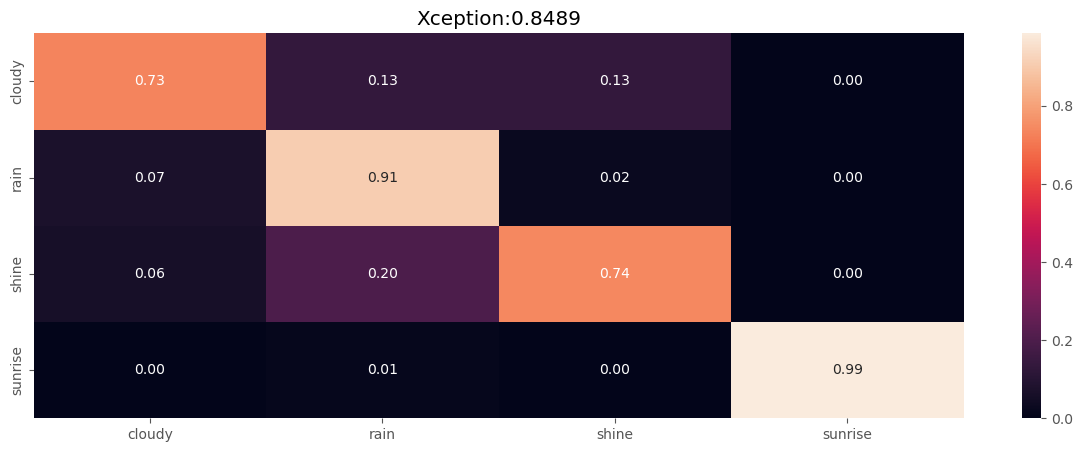

In [90]:
xception.compile(loss='categorical_crossentropy',
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

xception_history_2 = xception.fit(X_train, y_train_ohe, batch_size=64,
            epochs=50, verbose=1,
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
            )

summarize_net(xception, X_test, y_test, title_text='Xception:')

Epoch 1/50


2023-05-03 20:32:26.412812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 5s 276ms/step - loss: 1.5123 - accuracy: 0.2572 - val_loss: 1.1198 - val_accuracy: 0.8178
Epoch 2/50
15/15 [==============================] - 4s 264ms/step - loss: 1.4928 - accuracy: 0.3174 - val_loss: 1.5083 - val_accuracy: 0.7556
Epoch 3/50
15/15 [==============================] - 4s 287ms/step - loss: 1.4884 - accuracy: 0.3174 - val_loss: 1.6129 - val_accuracy: 0.7511
Epoch 4/50
15/15 [==============================] - 4s 280ms/step - loss: 1.4867 - accuracy: 0.3163 - val_loss: 1.7000 - val_accuracy: 0.7467
Epoch 5/50
8/8 [==============================] - 0s 43ms/step
Confusion Matrix
[[60  0  0  0]
 [15 27  1  0]
 [31  4 15  0]
 [ 8  0  0 64]]
Classification Report
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        60
           1       0.87      0.63      0.73        43
           2       0.94      0.30      0.45        50
           3       1.00      0.89      0.94        72

    accu

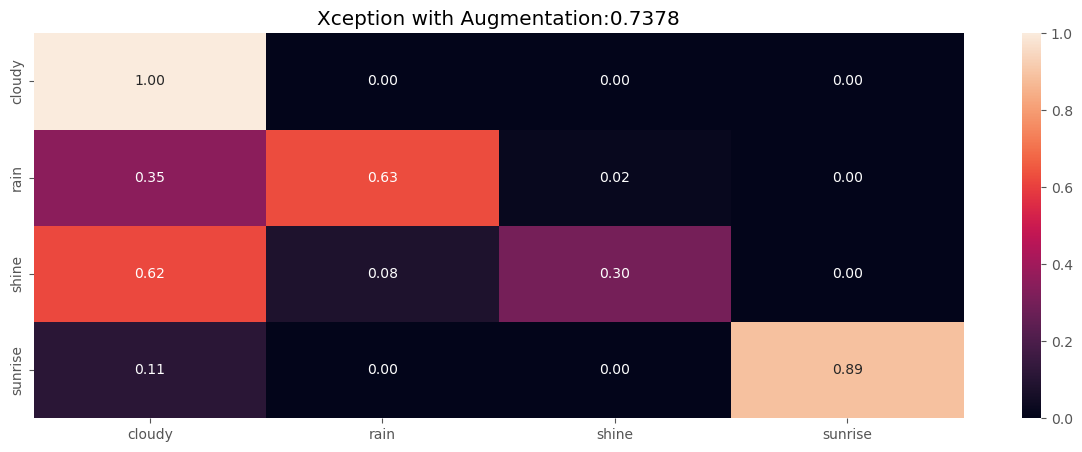

In [91]:
xception_with_augmentation_2 = xception.fit(datagen.flow(X_train, y_train_ohe, batch_size=64), 
                      # steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

summarize_net(xception, X_test, y_test, title_text='Xception with Augmentation:')

From above, we can see the changes we made did positively affect our results. The cloudy and rain images had more accurate predictions. Additionally, the percentage of false negatives decreased. 

Text(0.5, 0, 'epochs')

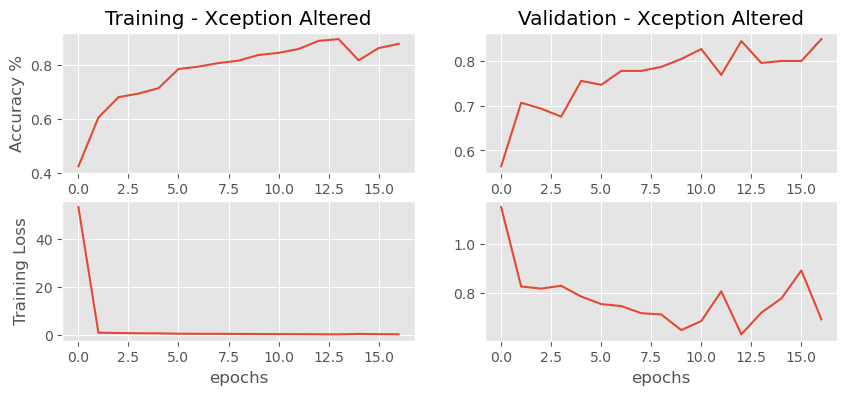

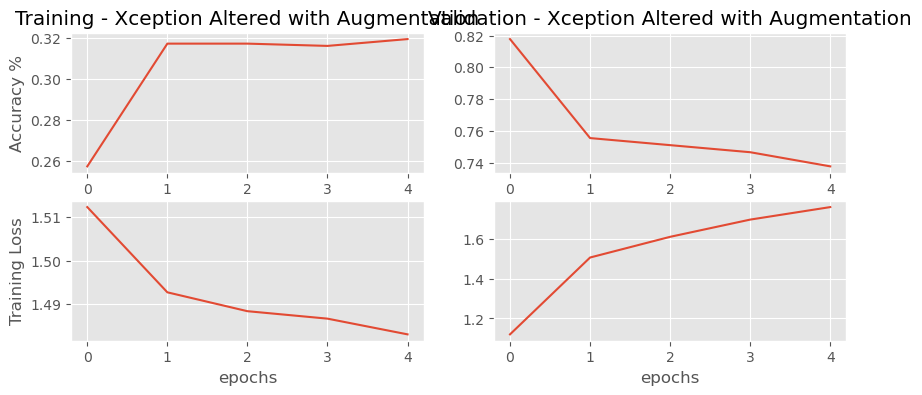

In [92]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(xception_history_2.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training - Xception Altered')
plt.subplot(2,2,2)
plt.plot(xception_history_2.history['val_accuracy'])
plt.title('Validation - Xception Altered')

plt.subplot(2,2,3)
plt.plot(xception_history_2.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(xception_history_2.history['val_loss'])
plt.xlabel('epochs')

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(xception_with_augmentation_2.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training - Xception Altered with Augmentation')
plt.subplot(2,2,2)
plt.plot(xception_with_augmentation_2.history['val_accuracy'])
plt.title('Validation - Xception Altered with Augmentation')

plt.subplot(2,2,3)
plt.plot(xception_with_augmentation_2.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(xception_with_augmentation_2.history['val_loss'])
plt.xlabel('epochs')

### 2.3 Visualize Final Results

We visualized the results of the best resnet and best xception. The best resnet and xception were the altered parameters with no augmentation.

The resnet had about 19 percent false negatives. However, the prediction accuracy for rain and cloudy images were at an all-time high for all the resnet models. 

The xception had about 15 percent false negatives. This is getting close to the percentage we need to be below for this algorithm to be useful in actual practice.

The xception did take longer to compile and fit. However, the difference was not great enough for our size dataset to factor in the decision. However, this difference might increase for larger sized datasets.

Text(0.5, 0, 'epochs')

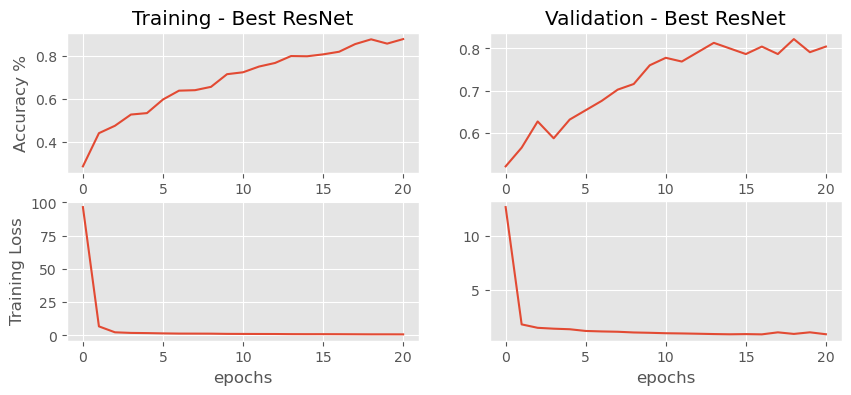

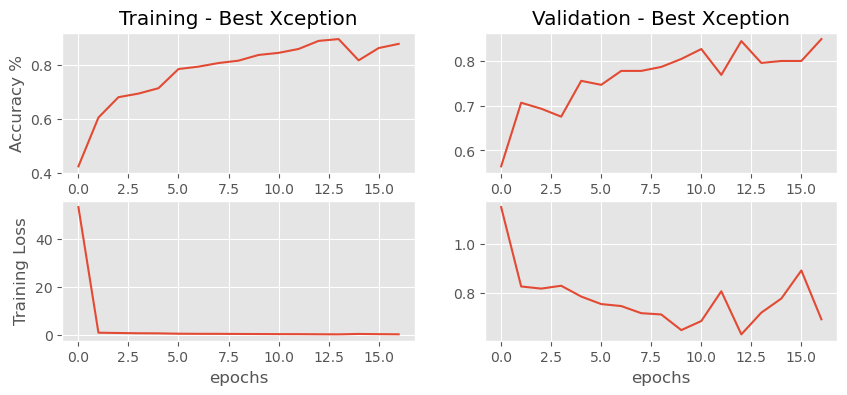

In [93]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(resnet_history_2 .history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training - Best ResNet')
plt.subplot(2,2,2)
plt.plot(resnet_history_2 .history['val_accuracy'])
plt.title('Validation - Best ResNet')

plt.subplot(2,2,3)
plt.plot(resnet_history_2 .history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(resnet_history_2 .history['val_loss'])
plt.xlabel('epochs')

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(xception_history_2.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training - Best Xception')
plt.subplot(2,2,2)
plt.plot(xception_history_2.history['val_accuracy'])
plt.title('Validation - Best Xception')

plt.subplot(2,2,3)
plt.plot(xception_history_2.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(xception_history_2.history['val_loss'])
plt.xlabel('epochs')

### 2.4 Compare CNN to MLP

We used the altered xception network that seemed to perform best in terms of accuracy, false negatives, and time to compare to a standard MLP using the AUC and ROC.

Since keras AUC of the ROC is best measured for binary classifiers. We will change our target classes from 4 to binary. We will group rain and cloudy together and group shine and sunrise together. These are most likely the ones that would be grouped together in actual practice. 

In [106]:
df = pd.DataFrame(y_train)
#['cloudy', 'rain', 'shine', 'sunrise'] = [0, 1, 2, 3]
y_train = df.replace([0, 1],[0, 0])
y_train = df.replace([2,3],[1, 1])
y_train = y_train.to_numpy()

df = pd.DataFrame(y_test)
y_test = df.replace([0,1],[0, 0])
y_test = df.replace([2,3],[1, 1])
y_test = y_test.to_numpy()

In [108]:
NUM_CLASSES = 2
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [128]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        print("Confusion Matrix for CNN")
        print(mt.confusion_matrix(y_test,yhat_cnn))
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        print("Classification Report for CNN")
        print(mt.classification_report(y_test,yhat_cnn))
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        print("Confusion Matrix for MLP")
        print(mt.confusion_matrix(y_test,yhat_mlp))
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        print("Classification Report for MLP")
        print(mt.classification_report(y_test,yhat_mlp))
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('MLP: '+str(acc_mlp))

In [110]:
# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=1, units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

In [111]:
l2_lambda = 0.000001

input_holder = Input(shape=(h, w, 3))

# start with a conv layer
x = Conv2D(filters=64,
               input_shape = (h,w,3),
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=64,
               input_shape = (h,w,3),
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=64,
               input_shape = (h,w,3),
               kernel_size=(3,3),
               kernel_initializer='glorot_uniform', 
               kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)

xception.compile(loss='categorical_crossentropy',
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

xception_history_2 = xception.fit(X_train, y_train_ohe, batch_size=64,
            epochs=50, verbose=1,
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
            )

Epoch 1/50
15/15 [==============================] - 6s 314ms/step - loss: 43.1061 - accuracy: 0.6102 - val_loss: 0.6039 - val_accuracy: 0.6844
Epoch 2/50
15/15 [==============================] - 4s 281ms/step - loss: 0.6384 - accuracy: 0.7160 - val_loss: 0.5828 - val_accuracy: 0.7378
Epoch 3/50
15/15 [==============================] - 4s 277ms/step - loss: 0.6179 - accuracy: 0.7316 - val_loss: 0.5570 - val_accuracy: 0.7378
Epoch 4/50
15/15 [==============================] - 4s 289ms/step - loss: 0.5997 - accuracy: 0.7372 - val_loss: 0.5599 - val_accuracy: 0.7511
Epoch 5/50
15/15 [==============================] - 5s 321ms/step - loss: 0.5588 - accuracy: 0.7561 - val_loss: 0.5249 - val_accuracy: 0.7689
Epoch 6/50
15/15 [==============================] - 4s 292ms/step - loss: 0.5478 - accuracy: 0.7695 - val_loss: 0.5269 - val_accuracy: 0.7867
Epoch 7/50
15/15 [==============================] - 4s 286ms/step - loss: 0.5257 - accuracy: 0.8018 - val_loss: 0.4976 - val_accuracy: 0.8356
Epoch

8/8 [==============================] - 0s 43ms/step
Confusion Matrix for CNN
[[ 20  40]
 [  2 163]]
Classification Report for CNN
              precision    recall  f1-score   support

           0       0.91      0.33      0.49        60
           1       0.80      0.99      0.89       165

    accuracy                           0.81       225
   macro avg       0.86      0.66      0.69       225
weighted avg       0.83      0.81      0.78       225

8/8 [==============================] - 0s 2ms/step
Confusion Matrix for MLP
[[  0  60]
 [  1 164]]
Classification Report for MLP
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.73      0.99      0.84       165

    accuracy                           0.73       225
   macro avg       0.37      0.50      0.42       225
weighted avg       0.54      0.73      0.62       225



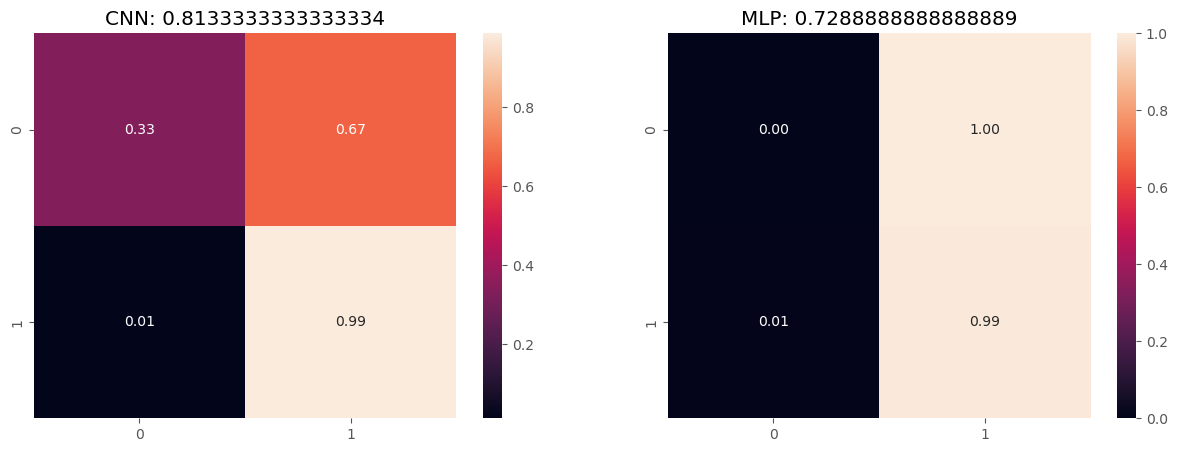

In [129]:
compare_mlp_cnn(xception,mlp,X_test,y_test)

From above, we can see that CNN performed better than MLP. Although MLP classified class 1 well, it did not classify any of class 0 correctly which is not good. CNN classified class 1 well also. It performed better on class 0 classification but not to our standards. This is definitely not the best visualization of this since we had to alter our classes to 2.

In [123]:
## code below taken from:
## https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_cnn = np.argmax(xception.predict(X_test), axis=1)
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_cnn)

auc_cnn = auc(fpr_cnn, tpr_cnn)

y_pred_mlp = np.argmax(mlp.predict(X_test), axis=1)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_pred_mlp)

auc_mlp = auc(fpr_mlp, tpr_mlp)

8/8 [==============================] - 0s 2ms/step


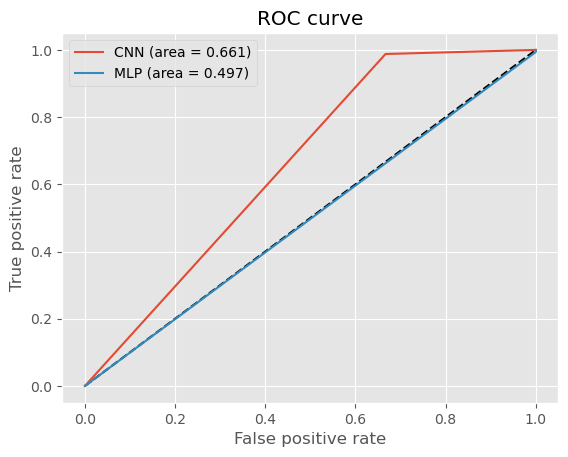

In [125]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

This visualization also helps demonstrate the better performance of CNN. However, it was not a significant difference.

## 3. Additional Analysis

We investigated the use of transfer learning and how it can improve our algorithm. 

In [133]:
NUM_CLASSES = 4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [135]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(898, 70, 70, 3)
(898, 1)
(225, 70, 70, 3)
(225, 1)


In [141]:
%%time
import cv2

X_train_up = [cv2.resize(x, dsize=(70,70,3), interpolation='INTER_NEAREST') for x in X_train]
X_train_up = np.stack(X_train_up, axis=0)
print(X_train_up.shape)

X_test_up = [cv2.resize(x, dsize=(70,70,3), interpolation='INTER_NEAREST') for x in X_test]
X_test_up = np.stack(X_test_up, axis=0)
print(X_test_up.shape)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Expected sequence length 2, got 3
>  - Can't parse 'dsize'. Expected sequence length 2, got 3


In [144]:
# connect new layers to the output
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = X_train[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time preds = res_no_top.predict(x)
preds.shape

1/1 [==============================] - 3s 3s/step
CPU times: user 1.57 s, sys: 1.21 s, total: 2.78 s
Wall time: 2.76 s


(1, 3, 3, 2048)

In [146]:
x_train = preprocess_input(X_train)
x_test = preprocess_input(X_test)

In [147]:
%%time
# train on half the data, to save a few hours
x_train_resnet = res_no_top.predict(x_train)
x_test_resnet = res_no_top.predict(x_test)
print(x_train_resnet.shape)

8/8 [==============================] - 2s 221ms/step
(898, 3, 3, 2048)
CPU times: user 38.9 s, sys: 50.3 s, total: 1min 29s
Wall time: 9.45 s


In [151]:
from keras.layers import SeparableConv2D
from keras.layers import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras import Input, Model


# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 3, 3, 2048)]      0         
                                                                 
 flatten_21 (Flatten)        (None, 18432)             0         
                                                                 
 dense_46 (Dense)            (None, 200)               3686600   
                                                                 
 dense_47 (Dense)            (None, 4)                 804       
                                                                 
Total params: 3,687,404
Trainable params: 3,687,404
Non-trainable params: 0
_________________________________________________________________


In [152]:
y_train_ohe_resnet = y_train_ohe[:x_train_resnet.shape[0]]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))

Epoch 1/5
15/15 [==============================] - 1s 58ms/step - loss: 5.5864 - accuracy: 0.7728 - val_loss: 0.3306 - val_accuracy: 0.9600
Epoch 2/5
15/15 [==============================] - 1s 45ms/step - loss: 0.1560 - accuracy: 0.9811 - val_loss: 1.0553 - val_accuracy: 0.8711
Epoch 3/5
15/15 [==============================] - 1s 47ms/step - loss: 0.2873 - accuracy: 0.9655 - val_loss: 0.0697 - val_accuracy: 0.9867
Epoch 4/5
15/15 [==============================] - 1s 47ms/step - loss: 0.0463 - accuracy: 0.9911 - val_loss: 0.1515 - val_accuracy: 0.9689
Epoch 5/5
15/15 [==============================] - 1s 50ms/step - loss: 0.0086 - accuracy: 0.9978 - val_loss: 0.1787 - val_accuracy: 0.9778


8/8 [==============================] - 0s 9ms/step
Confusion Matrix
[[57  1  2  0]
 [ 0 43  0  0]
 [ 0  0 49  1]
 [ 0  0  1 71]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        60
           1       0.98      1.00      0.99        43
           2       0.94      0.98      0.96        50
           3       0.99      0.99      0.99        72

    accuracy                           0.98       225
   macro avg       0.98      0.98      0.98       225
weighted avg       0.98      0.98      0.98       225



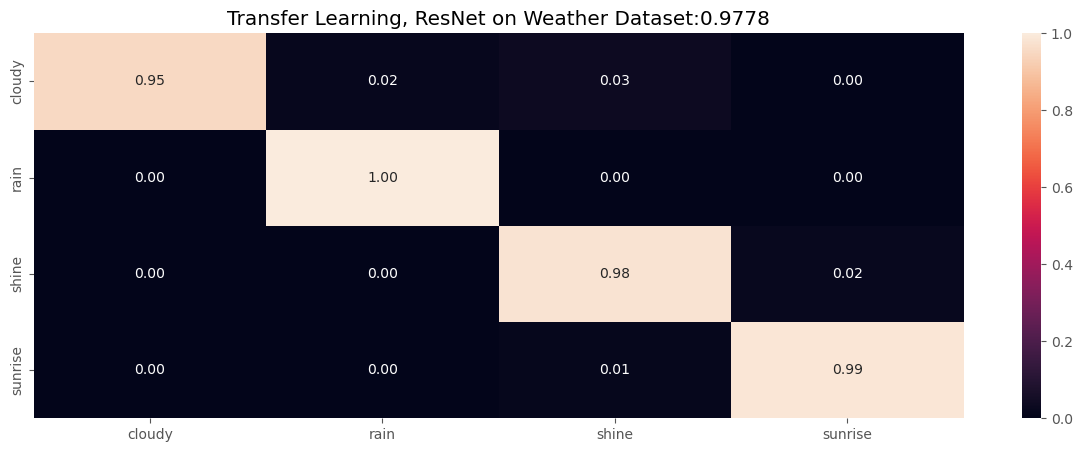

In [153]:
summarize_net(model, x_test_resnet, y_test[:x_test_resnet.shape[0]], title_text='Transfer Learning, ResNet on Weather Dataset:')

Wow! This is amazing. We only had 5 false negatives. The prediction accuracy was almost 100% correct. This is a major improvement especially for oru cloudy and rain images. The rain images had no errors while the cloudy images had a few incorrect predictions. This was only due to one fit. We will next see if it can improve with another fit.

In [154]:
model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))

Epoch 1/5
15/15 [==============================] - 1s 54ms/step - loss: 0.1781 - accuracy: 0.9744 - val_loss: 0.2650 - val_accuracy: 0.9689
Epoch 2/5
15/15 [==============================] - 1s 62ms/step - loss: 0.0688 - accuracy: 0.9922 - val_loss: 0.2004 - val_accuracy: 0.9689
Epoch 3/5
15/15 [==============================] - 1s 67ms/step - loss: 0.0060 - accuracy: 0.9978 - val_loss: 0.2150 - val_accuracy: 0.9644
Epoch 4/5
15/15 [==============================] - 1s 61ms/step - loss: 0.3214 - accuracy: 0.9800 - val_loss: 0.2672 - val_accuracy: 0.9733
Epoch 5/5
15/15 [==============================] - 1s 60ms/step - loss: 4.4134e-04 - accuracy: 1.0000 - val_loss: 0.2417 - val_accuracy: 0.9778


8/8 [==============================] - 0s 3ms/step
Confusion Matrix
[[59  0  1  0]
 [ 2 41  0  0]
 [ 0  0 49  1]
 [ 0  0  1 71]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        60
           1       1.00      0.95      0.98        43
           2       0.96      0.98      0.97        50
           3       0.99      0.99      0.99        72

    accuracy                           0.98       225
   macro avg       0.98      0.98      0.98       225
weighted avg       0.98      0.98      0.98       225



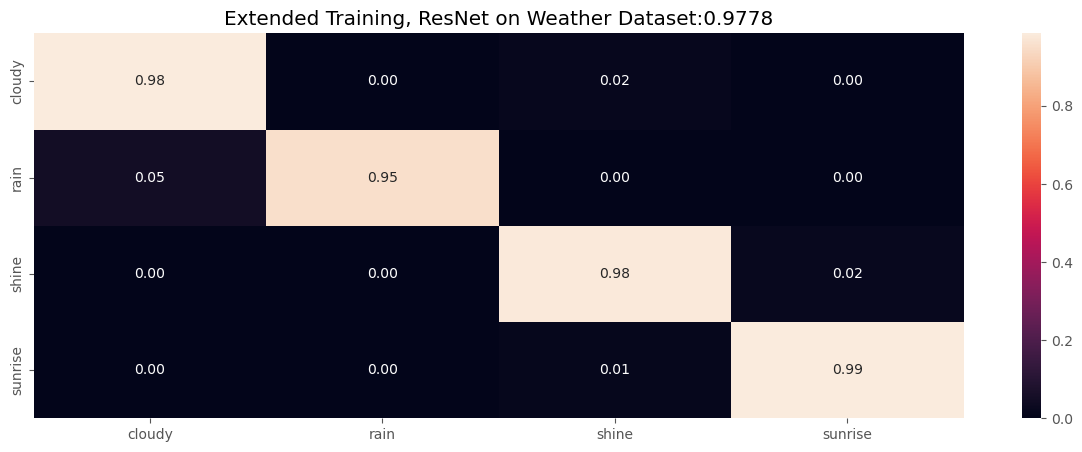

In [155]:
summarize_net(model, x_test_resnet, y_test[:x_test_resnet.shape[0]], title_text='Extended Training, ResNet on Weather Dataset:')

We can see that the improvement was not that great. The cloudy image prediction improved, but the rain image prediction accuracy decreased. The number of false negatives was still the same. Thus, this does not necessarily help in terms of our metric, false negatives count. However, these values and percentages are definitely in the acceptable range for our business use case. 